# CPSC 330 - Applied Machine Learning 

## Homework 6: Putting it all together 
### Associated lectures: All material till lecture 13 

**Due date: Monday, November 15, 2021 at 11:59pm**

<font color="green">
    
**Seyed Arman Abtahi** 59678110
    
In collaboration with **Charvi Gulati**

## Table of contents

- [Submission instructions](#si)
- [Understanding the problem](#1)
- [Data splitting](#2)
- [EDA](#3)
- (Optional) [Feature engineering](#4)
- [Preprocessing and transformations](#5)
- [Baseline model](#6)
- [Linear models](#7)
- [Different classifiers](#8)
- (Optional) [Feature selection](#9)
- [Hyperparameter optimization](#10)
- [Interpretation and feature importances](#11)
- [Results on the test set](#12)
- (Optional) [Explaining predictions](#13)
- [Summary of the results](#14)

## Imports 

In [1]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb


from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier 
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    precision_recall_curve,
    precision_score,
    recall_score
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
    cross_val_predict,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from scipy.stats import expon, lognorm, loguniform, randint, uniform

from sklearn.feature_selection import RFECV
from sklearn.utils.class_weight import compute_sample_weight

import eli5
import shap

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.4f (+/- %0.4f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

/Users/seyedarmanabtahi/opt/anaconda3/envs/cpsc330/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


<font color="green">
We have taken codes and functions from lecture material CPSC330

<br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br>

## Introduction <a name="in"></a>
<hr>

At this point we are at the end of supervised machine learning part of the course. So in this homework, you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips

1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 
4. If you are having trouble running models on your laptop because of the size of the dataset, you can create your train/test split in such a way that you have less data in the train split. If you end up doing this, please write a note to the grader in the submission explaining why you are doing it.  

#### Assessment

We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.

#### A final note

Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (4-10 hours) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

## 1. Understanding the problem <a name="1"></a>
<hr>
rubric={points:4}

In this mini project, you will be working on a classification problem of predicting whether a credit card client will default or not. 
For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. You can find this information in the documentation on [the dataset page on Kaggle](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 

In [2]:
df = pd.read_csv("UCI_Credit_Card.csv")

In [3]:
print(df.shape)

(30000, 25)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

<br><br>

<font color='green'>
    
- we see that all 24 features have 30000 counts which indicates there is no missing value.

- ID is irrelevant and needs to be dropped.
    
- "SEX" also may make the model bias and we drop this feature as well.
    
- Data set has 30 k data. We have lots of data so I'll keep 20% for testing.
    
- "EDUCATION" and "PAY_X" are already kind of ordinal. Rest are categorical and numerical features.
    
- Other features are status of payments and statements.
    
- We also need to rename "PAY_0" to "PAY_1" for consistency.
    
- for "PAY_X" I assume values -2 means that "inactive"  and 0 means "No consumption".

In [5]:
df = df.rename(columns={"PAY_0":"PAY_1"})
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [6]:
target="default.payment.next.month"
feats = list(df.drop(columns=target).columns)

## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train and test portions. 

In [7]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

<br><br>

## 3. EDA <a name="3"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

<font color='green'>
        
- SEX, EDUCATION, MARRIAGE, PAY_1, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6 are categorical features.
    
- Rest are numerical features.

In [8]:
default=train_df[train_df[target] == 1]
repay=train_df[train_df[target] == 0]

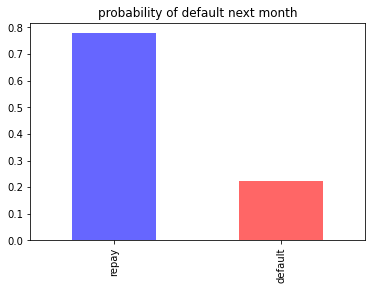

In [9]:
train_df[target].value_counts(normalize=True).rename(index={0:"repay",1:"default"}).plot(kind="bar",color=["blue","red"],alpha=0.6,).set_title("probability of default next month");

<font color='green' >
From these histogram, obviously we have class imbalance.

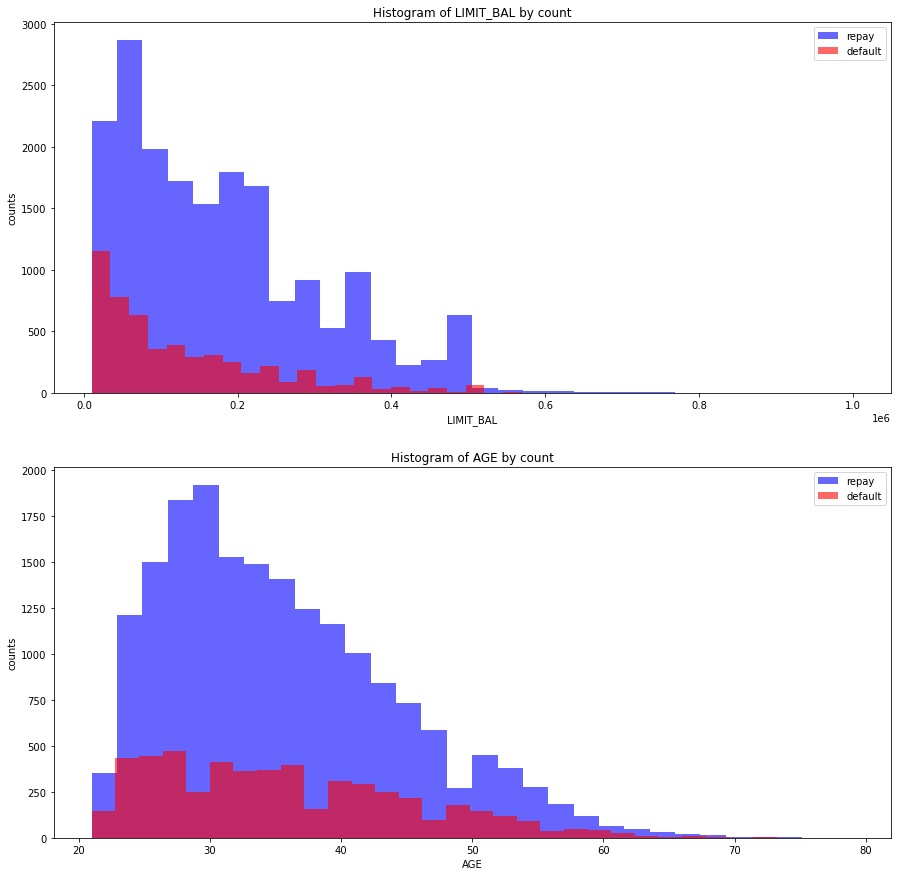

In [10]:
feature=["LIMIT_BAL","AGE"]
n=len(feature)
fig, ax = plt.subplots(n, sharey=False, figsize=[15, 15])
#fig.suptitle("Histograms of a couple of feature by target class")
for i,name in enumerate(feature):
    ax[i].hist(repay[[name]],bins=30 ,alpha=0.6, label='repay',color="blue")
    ax[i].hist(default[[name]],bins=30 ,alpha=0.6, label='default',color="red")
    ax[i].set_title("Histogram of " +name + " by count" )
    ax[i].set_xlabel(name)
    ax[i].set_ylabel('counts')
    ax[i].legend(loc="upper right")

plt.show()

<font color='green' >
    
- From these histograms each feature solely cannot predict default.
    
- There are more younger customers. 
    
- More people have credit limit less than 200,000.

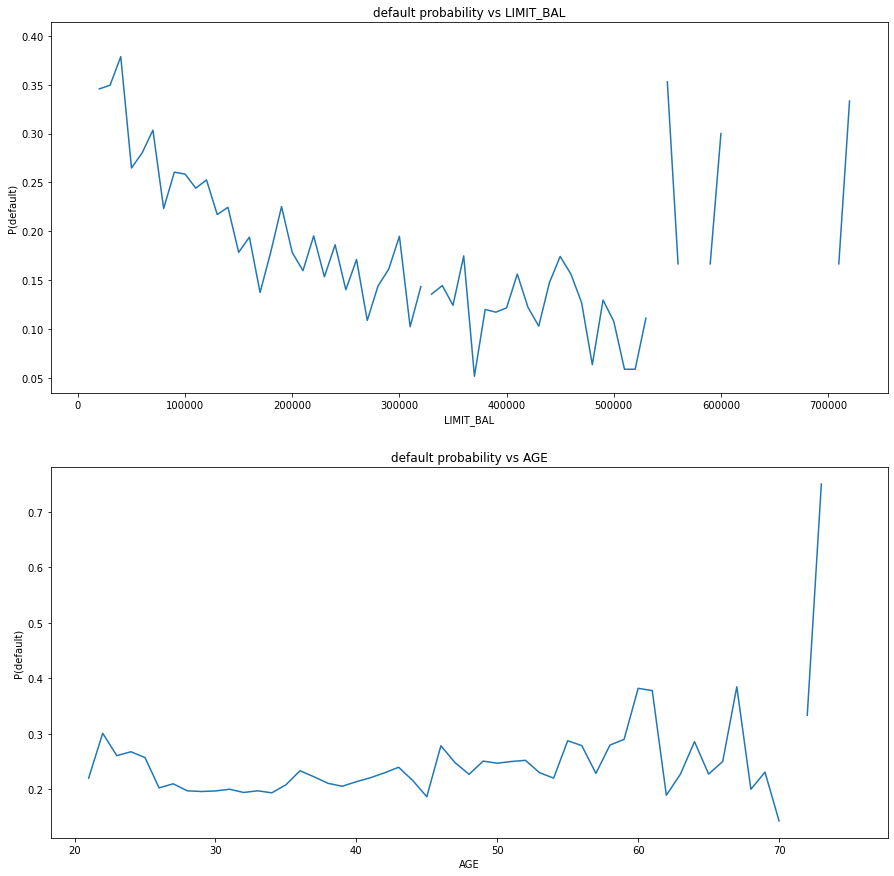

In [11]:
feature=["LIMIT_BAL","AGE"]
n=len(feature)
fig, ax = plt.subplots(n, sharey=False, figsize=[15, 15])
#fig.suptitle("Histograms of a couple of feature by target class")
for i,name in enumerate(feature):
    repay2 = repay[name].value_counts()
    default2 = default[name].value_counts()
    ax[i].plot(default2/(default2+repay2))
    ax[i].set_title("default probability vs " +name)
    ax[i].set_xlabel(name)
    ax[i].set_ylabel('P(default)')

<font color='green' >
    
- Customers with lower credit limit, default more than customers with higher credit limits.
    
- Probability of default doesn't change with age.
    
- We are ignoring those jumps as there are few customers in that region (outliers) and only looking at the general trend.

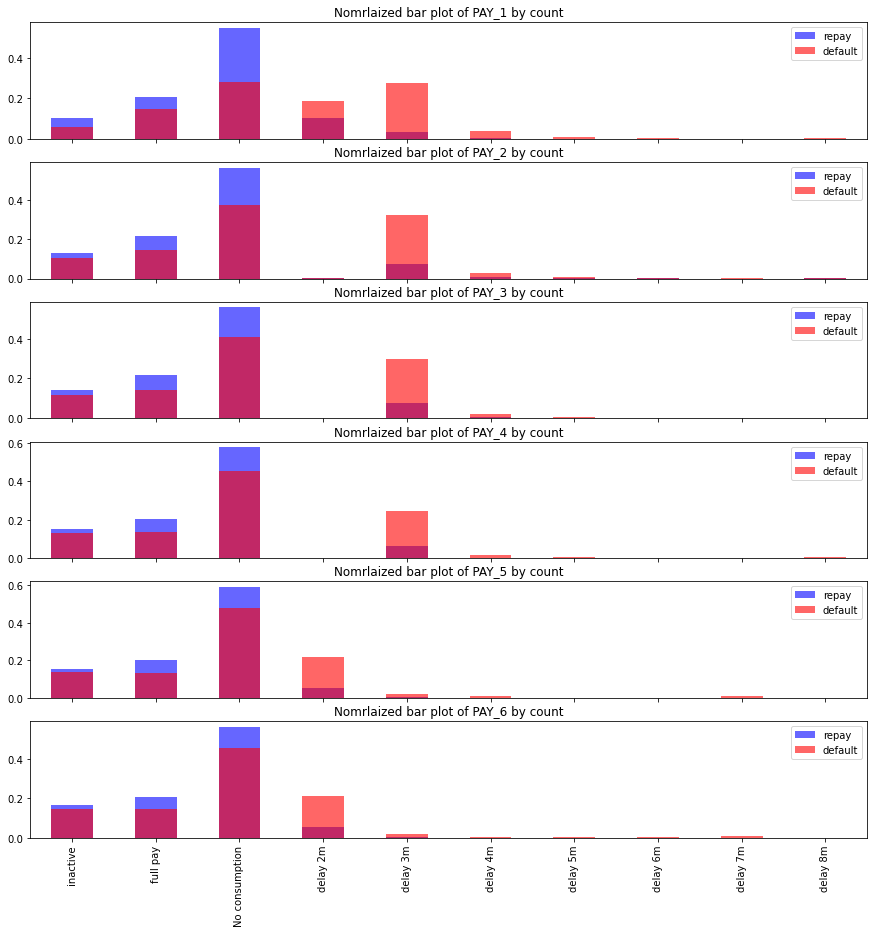

In [12]:
feature=["PAY_1","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]
n=len(feature)
list={-2:"inactive",-1:"full pay", 0:"No consumption",1:"delay 1m", 2:"delay 2m", 3:"delay 3m",4: "delay 4m",5: "delay 5m",6: "delay 6m",7: "delay 7m", 8:"delay 8m",9: "delay 9m"}
fig, ax = plt.subplots(n, sharex=True, figsize=[15, 15])
for i,name in enumerate(feature):
    repay2 = repay[name].value_counts(normalize=True).sort_index().rename(index=list)
    default2 = default[name].value_counts(normalize=True).sort_index().rename(index=list)
    repay2.plot(kind='bar',alpha=0.6, ax=ax[i],label='repay',color='blue').set_title("Nomrlaized bar plot of " +name + " by count" )
    default2.plot(kind='bar',alpha=0.6, ax=ax[i],label='default',color='red').set_title("Nomrlaized bar plot of " +name + " by count" )
    ax[i].legend(loc="upper right")

plt.show()

<font color='green' >
    This shows that there is a high chance that customers having debt already default next month.

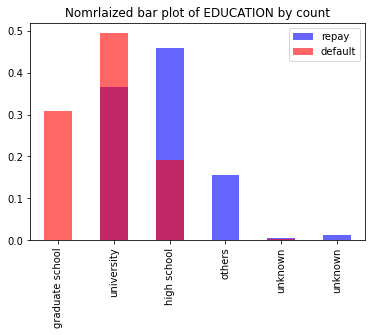

In [13]:
list={0:'unknown',1:'graduate school', 2:'university', 3:'high school', 4:'others', 5:'unknown', 6:'unknown'}
repay2 = repay["EDUCATION"].value_counts(normalize=True).sort_index().rename(index=list)
default2 = default["EDUCATION"].value_counts(normalize=True).sort_index().rename(index=list)
repay2.plot(kind='bar',alpha=0.6, label='repay',color='blue',legend='repay').set_title("Nomrlaized bar plot of EDUCATION by count" )
default2.plot(kind='bar',alpha=0.6, label='default',color='red',legend='default');

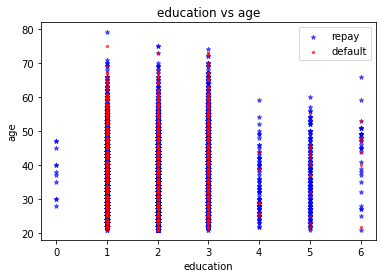

In [14]:
plt.scatter(repay["EDUCATION"],repay["AGE"],marker="*",s=20,alpha=0.6, label='repay',color="blue")
plt.scatter(default["EDUCATION"],default["AGE"],marker="o",s=5,alpha=0.6, label='default',color="red")
plt.legend(loc="upper right")
plt.ylabel("age")
plt.xlabel("education");
plt.title("education vs age");

<font color='green' >
Defaulters are mostly among university graduates!

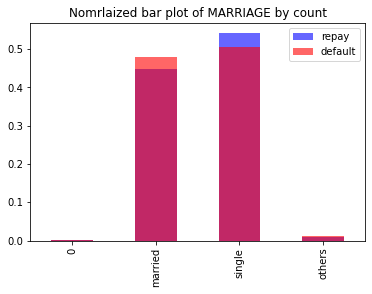

In [15]:
list={1:'married', 2:'single', 3:'others'}

repay2 = repay["MARRIAGE"].value_counts(normalize=True).sort_index().rename(index=list)
default2 = default["MARRIAGE"].value_counts(normalize=True).sort_index().rename(index=list)
repay2.plot(kind='bar',alpha=0.6, label='repay',color='blue',legend='repay').set_title("Nomrlaized bar plot of MARRIAGE by count" )
default2.plot(kind='bar',alpha=0.6, label='default',color='red',legend='default');

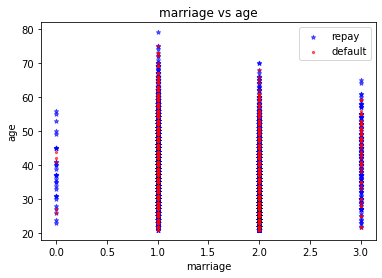

In [16]:
plt.scatter(repay["MARRIAGE"],repay["AGE"],marker="*",s=20,alpha=0.6, label='repay',color="blue")
plt.scatter(default["MARRIAGE"],default["AGE"],marker="o",s=5,alpha=0.6, label='default',color="red")
plt.legend(loc="upper right")
plt.ylabel("age")
plt.xlabel("marriage");
plt.title("marriage vs age");

<font color='green' >
Unmarried customers have a bit higher probability to default next month

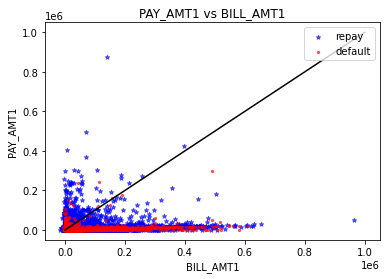

In [17]:
plt.scatter(repay["BILL_AMT1"],repay["PAY_AMT1"],marker="*",s=20,alpha=0.6, label='repay',color="blue")
plt.scatter(default["BILL_AMT1"],default["PAY_AMT1"],marker="o",s=5,alpha=0.6, label='default',color="red")
plt.plot([1,10**6],[1,10**6],color="black")
plt.legend(loc="upper right")
plt.ylabel("PAY_AMT1")
plt.xlabel("BILL_AMT1");
plt.title("PAY_AMT1 vs BILL_AMT1");

<font color='green' >
In general, a lot of clients pay less than the bill amount.

In [18]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,24000.0,14964.174292,8660.479272,1.0,7467.75,14975.0,22460.25,30000.0
LIMIT_BAL,24000.0,167893.486667,130109.666875,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,24000.0,1.603125,0.489260,1.0,1.00,2.0,2.00,2.0
EDUCATION,24000.0,1.851958,0.790560,0.0,1.00,2.0,2.00,6.0
MARRIAGE,24000.0,1.553375,0.521452,0.0,1.00,2.0,2.00,3.0
AGE,24000.0,35.488458,9.217424,21.0,28.00,34.0,41.00,79.0
PAY_1,24000.0,-0.017542,1.125331,-2.0,-1.00,0.0,0.00,8.0
PAY_2,24000.0,-0.135292,1.199812,-2.0,-1.00,0.0,0.00,8.0
PAY_3,24000.0,-0.170042,1.201709,-2.0,-1.00,0.0,0.00,8.0
PAY_4,24000.0,-0.224292,1.170630,-2.0,-1.00,0.0,0.00,8.0


In [19]:
train_df[target].mean()

0.22216666666666668

<font color='green'>
Class imbalance : 22% one class and 78 percent the other class. I would pick recall score to pick less false negatives as we need to identify more customers that may default. But at the same time, I look for roc-auc too.

<br><br>

## (Optional) 4. Feature engineering <a name="4"></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

<font color='green'>
We can take a look on the heat map of the feature correlation for unscaled data.

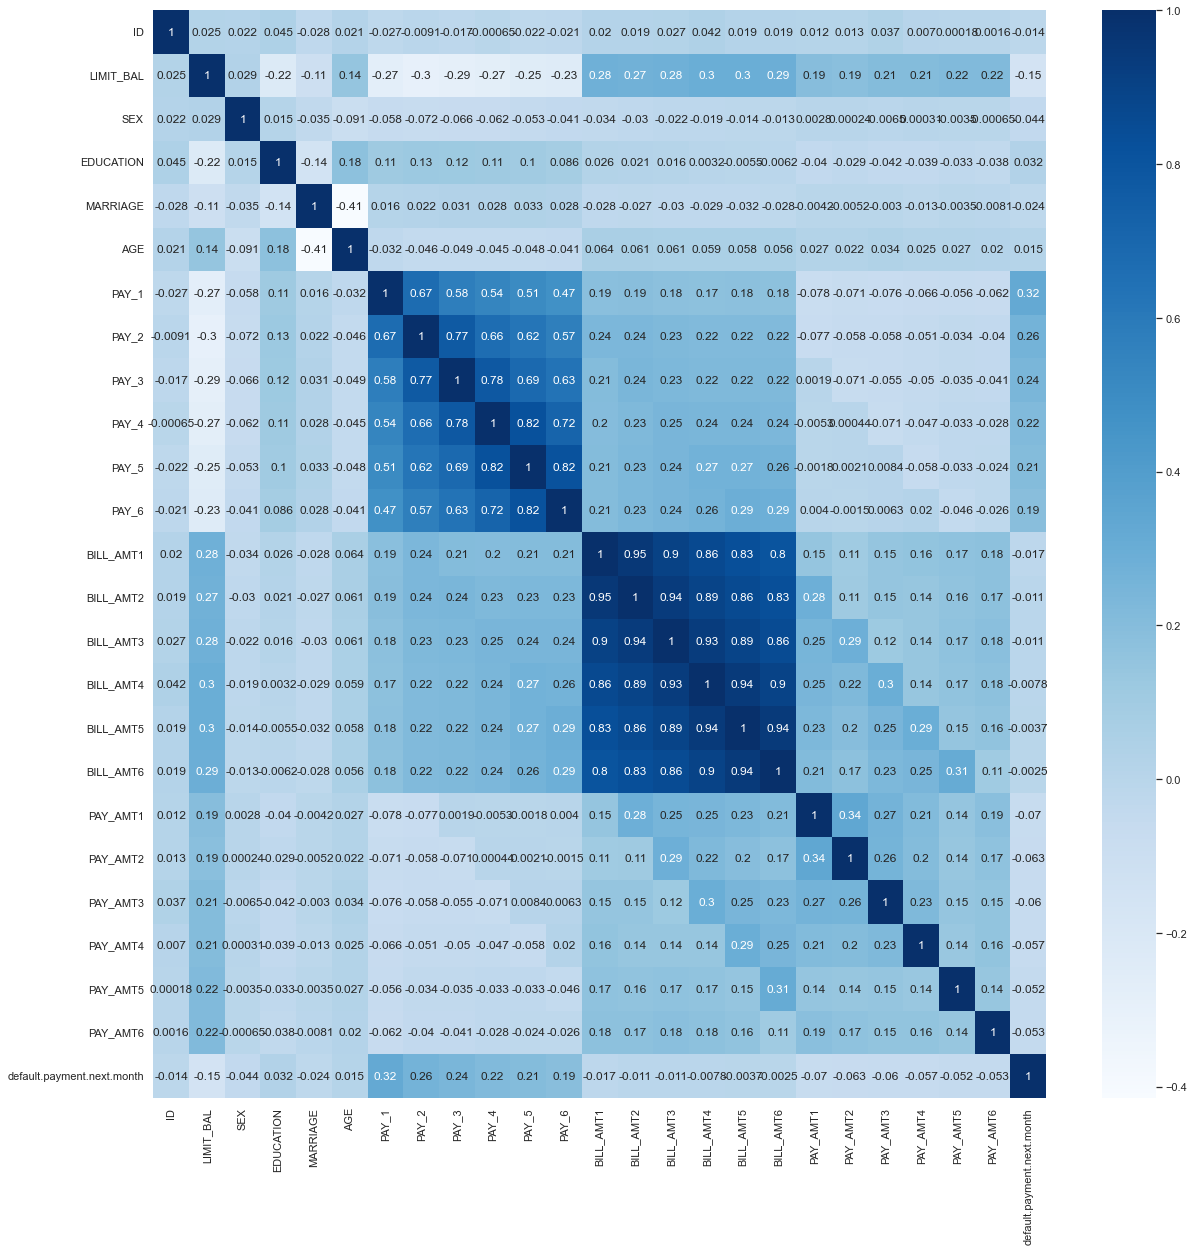

In [20]:
cor = train_df.corr()
plt.figure(figsize=(20, 20))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

<font color='green'>

We can see that Bill amounts (BILL_AMTX) are really correlated to one another. Specially each two consecutive bills. 
    
Payment status are also correlated(PAY_X). 

The prediction for next month default is highly dependent on the payment status in the last six months.

We try to reduce the non important features later in this project.

<br><br>

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

In [21]:
X_train=train_df.drop(columns=target)
X_test=test_df.drop(columns=target)
y_train=train_df[target]
y_test=test_df[target]

In [22]:
numerical_features=[ 'LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
ordinal_features=['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
categorical_features=['MARRIAGE','EDUCATION']
passthrough_features = []
drop_features=['ID','SEX']

features=numerical_features+ordinal_features+categorical_features+passthrough_features+drop_features
assert set(features)==set(feats)

<font color="green">
We keep Education in categorical features instead of ordinal, as this improves the score later on!

In [23]:
numeric_transformer=make_pipeline(SimpleImputer(strategy="median"),StandardScaler())
ordinal_transformer=make_pipeline(SimpleImputer(strategy="most_frequent"))
categorical_transformer=make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown='ignore',sparse=False))

In [24]:
preprocessor=make_column_transformer(
    (numeric_transformer,numerical_features),
    (ordinal_transformer,ordinal_features),
    (categorical_transformer,categorical_features),
    ("passthrough",passthrough_features),
    ("drop",drop_features),
)

In [25]:
X_train_transformed=preprocessor.fit_transform(X_train)

column_names=(
    numerical_features
    +ordinal_features
    +preprocessor.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(categorical_features).tolist()
    +passthrough_features
)

In [26]:
X_train_transformed=pd.DataFrame(X_train_transformed,index=X_train.index, columns=column_names)
X_train_transformed.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6
19682,0.246770,1.140423,0.757746,0.761414,0.830643,0.929712,0.901952,0.444775,-0.117221,-0.042650,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11062,-0.368109,-0.378471,-0.647736,-0.684308,-0.677352,-0.664583,-0.648784,-0.646675,-0.298634,-0.261604,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
197,-1.136707,-1.463396,-0.443283,-0.415538,-0.405142,-0.542919,-0.352021,-0.327893,-0.248029,-0.228531,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
23620,-0.521828,-0.161486,0.553566,0.595190,0.585249,-0.312957,-0.535129,-0.597934,-0.038927,-0.098349,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
26031,0.938509,-0.703949,-0.596367,-0.573988,-0.560226,-0.536136,-0.511737,-0.483417,-0.270109,-0.206514,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


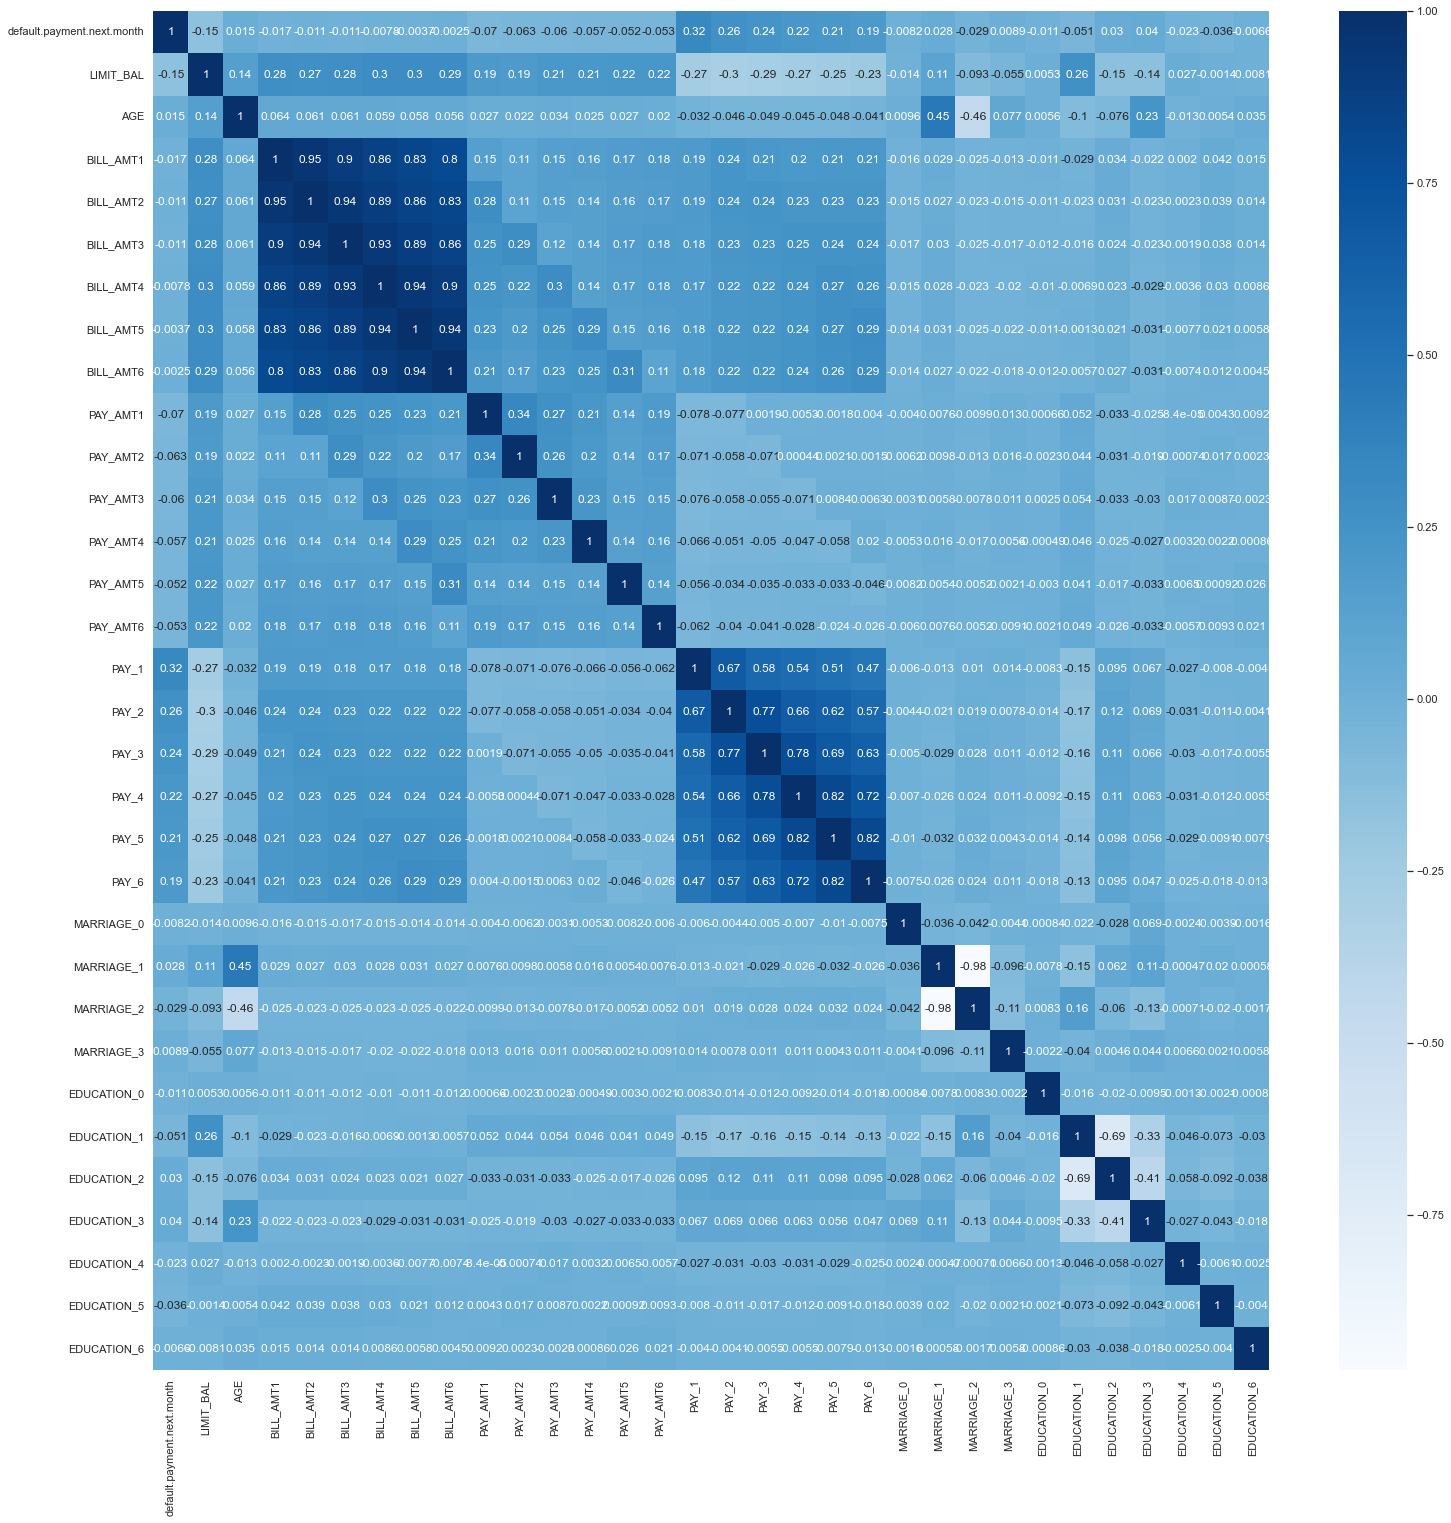

In [27]:
cor = pd.concat((y_train, X_train_transformed), axis=1).corr()
plt.figure(figsize=(25, 25))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

<br><br>

## 6. Baseline model <a name="6"></a>
<hr>

rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

In [28]:
scoring=["accuracy","recall"]
pipe_dc=make_pipeline(preprocessor,DummyClassifier())
scores=cross_validate(pipe_dc,  X_train, y_train,  scoring=scoring,cv=5,return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall
0,0.058015,0.018084,0.777917,0.777813,0.0,0.0
1,0.076833,0.013283,0.777917,0.777813,0.0,0.0
2,0.070374,0.013510,0.777917,0.777813,0.0,0.0
3,0.058958,0.010963,0.777708,0.777865,0.0,0.0
4,0.053814,0.011352,0.777708,0.777865,0.0,0.0


<font color='green'>
The test accuracy is 77.7 percent and recall is 0. 

In [29]:
cm_dc=confusion_matrix(y_train, cross_val_predict(pipe_dc, X_train, y_train))
print("Dummy Classifier\nTN=%d  FP=%d\nFN=%d   TP=%d"%(cm_dc[0,0],cm_dc[0,1],cm_dc[1,0],cm_dc[1,1]))

Dummy Classifier
TN=18668  FP=0
FN=5332   TP=0


<font color='green'>
The classifier predicts no default

<br><br>

## 7. Linear models <a name="7"></a>
<hr>
rubric={points:12}

**Your tasks:**

1. Try logistic regression as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter `C`. 
3. Report validation scores along with standard deviation. 
4. Summarize your results.

<font color="green" >
We look for different scoring metrics for now to have an idea on the performance.

In [30]:
scores={}
scoring=["accuracy", "precision", "recall","f1","roc_auc","average_precision"]
pipe_lr_none=make_pipeline(preprocessor,LogisticRegression(max_iter=1000))
scores["class weight: None"]=mean_std_cross_val_scores(pipe_lr_none,  X_train,y_train,scoring=scoring,cv=5,return_train_score=True)

pipe_lr_balanced=make_pipeline(preprocessor,LogisticRegression(class_weight="balanced",max_iter=1000))
scores["class weight: Balanced"]=mean_std_cross_val_scores(pipe_lr_balanced,  X_train,y_train,scoring=scoring,cv=5,return_train_score=True)

pd.DataFrame(scores)

,class weight: None,class weight: Balanced
fit_time,0.4011 (+/- 0.0747),0.2783 (+/- 0.0603)
score_time,0.0282 (+/- 0.0055),0.0234 (+/- 0.0022)
test_accuracy,0.8100 (+/- 0.0045),0.6836 (+/- 0.0079)
train_accuracy,0.8106 (+/- 0.0014),0.6838 (+/- 0.0032)
test_precision,0.7215 (+/- 0.0270),0.3755 (+/- 0.0106)
train_precision,0.7241 (+/- 0.0037),0.3763 (+/- 0.0035)
test_recall,0.2359 (+/- 0.0194),0.6403 (+/- 0.0251)
train_recall,0.2384 (+/- 0.0099),0.6435 (+/- 0.0046)
test_f1,0.3553 (+/- 0.0237),0.4734 (+/- 0.0145)
train_f1,0.3586 (+/- 0.0113),0.4749 (+/- 0.0036)


In [31]:
cm_none=confusion_matrix(y_train, cross_val_predict(pipe_lr_none, X_train, y_train))
cm_balanced=confusion_matrix(y_train, cross_val_predict(pipe_lr_balanced, X_train, y_train))
print("class weight: None\nTN=%d  FP=%d\nFN=%d   TP=%d"%(cm_none[0,0],cm_none[0,1],cm_none[1,0],cm_none[1,1]))
print("\nclass weight: Balanced\nTN=%d  FP=%d\nFN=%d   TP=%d"%(cm_balanced[0,0],cm_balanced[0,1],cm_balanced[1,0],cm_balanced[1,1]))

class weight: None
TN=18182  FP=486
FN=4074   TP=1258

class weight: Balanced
TN=12992  FP=5676
FN=1918   TP=3414


<font color="green">
    We already can see that by balancing the classes, we get a better recall score and less false negatives. The cost associated with it is higher false positives.

<font color="green" >
    
**Hyperparameter tuning:**

In [32]:
param = [0.001, 0.01, 0.1, 1.0, 10, 100]
scores={}
best_score=0
for C in param:
    pipe_lr=make_pipeline(preprocessor,LogisticRegression(solver='lbfgs',penalty='l2',class_weight="balanced",C=C,max_iter=1000))
    scores["C="+str(round(C,3))]=mean_std_cross_val_scores(pipe_lr,  X_train,y_train,scoring=scoring,cv=5,return_train_score=True)
    if best_score<float(scores["C="+str(round(C,3))]["test_recall"][:6]):
        best_score=float(scores["C="+str(round(C,3))]["test_recall"][:6])
        best_C=C
    
pd.DataFrame(scores)    

,C=0.001,C=0.01,C=0.1,C=1.0,C=10,C=100
fit_time,0.0820 (+/- 0.0095),0.1577 (+/- 0.0318),0.2114 (+/- 0.0840),0.2719 (+/- 0.0616),0.2883 (+/- 0.0578),0.3826 (+/- 0.1496)
score_time,0.0241 (+/- 0.0014),0.0312 (+/- 0.0056),0.0260 (+/- 0.0086),0.0238 (+/- 0.0015),0.0234 (+/- 0.0014),0.0222 (+/- 0.0017)
test_accuracy,0.6901 (+/- 0.0067),0.6883 (+/- 0.0075),0.6854 (+/- 0.0078),0.6836 (+/- 0.0079),0.6834 (+/- 0.0080),0.6833 (+/- 0.0080)
train_accuracy,0.6906 (+/- 0.0037),0.6884 (+/- 0.0039),0.6854 (+/- 0.0031),0.6838 (+/- 0.0032),0.6834 (+/- 0.0032),0.6834 (+/- 0.0032)
test_precision,0.3796 (+/- 0.0090),0.3794 (+/- 0.0102),0.3773 (+/- 0.0104),0.3755 (+/- 0.0106),0.3754 (+/- 0.0107),0.3753 (+/- 0.0106)
train_precision,0.3805 (+/- 0.0040),0.3801 (+/- 0.0043),0.3777 (+/- 0.0034),0.3763 (+/- 0.0035),0.3759 (+/- 0.0034),0.3759 (+/- 0.0035)
test_recall,0.6226 (+/- 0.0292),0.6339 (+/- 0.0242),0.6397 (+/- 0.0245),0.6403 (+/- 0.0251),0.6405 (+/- 0.0248),0.6405 (+/- 0.0248)
train_recall,0.6249 (+/- 0.0051),0.6378 (+/- 0.0042),0.6421 (+/- 0.0044),0.6435 (+/- 0.0046),0.6436 (+/- 0.0045),0.6437 (+/- 0.0045)
test_f1,0.4715 (+/- 0.0138),0.4746 (+/- 0.0140),0.4746 (+/- 0.0142),0.4734 (+/- 0.0145),0.4733 (+/- 0.0146),0.4732 (+/- 0.0145)
train_f1,0.4730 (+/- 0.0037),0.4763 (+/- 0.0042),0.4756 (+/- 0.0034),0.4749 (+/- 0.0036),0.4746 (+/- 0.0035),0.4746 (+/- 0.0036)


In [33]:
print("The best validation recall score is  %4.4f" %best_score)
print("The best value found for C is C=%2.3f and the class_weight set to \"balanced\"" %(best_C))

The best validation recall score is  0.6405
The best value found for C is C=10.000 and the class_weight set to "balanced"


In [34]:
pipe_lr_balanced_C=make_pipeline(preprocessor,LogisticRegression(max_iter=1000,class_weight="balanced",C=best_C))
cm_balanced_C=confusion_matrix(y_train, cross_val_predict(pipe_lr_balanced_C, X_train, y_train))
print("\nclass weight: Balanced,  C=%.3f\nTN=%d  FP=%d\nFN=%d   TP=%d"%(best_C,cm_balanced_C[0,0],cm_balanced_C[0,1],cm_balanced_C[1,0],cm_balanced_C[1,1]))


class weight: Balanced,  C=10.000
TN=12987  FP=5681
FN=1917   TP=3415


<font color='green'>
With a balanced weight, we can get a recall score of 64% and 37.5% precision.
Looking at different loss functions and regularization didn't help improving any scores.   
    
Let's see if we can get a better recall score using different classifiers.

<br><br>

## 8. Different classifiers <a name="8"></a>
<hr>
rubric={points:15}

**Your tasks:**
1. Try at least 3 other models aside from logistic regression. At least one of these models should be a tree-based ensemble model (e.g., lgbm, random forest, xgboost). 
2. Summarize your results. Can you beat logistic regression? 

<font color="green">
    
Let's try different classifiers

In [35]:
sample_weights = compute_sample_weight(class_weight='balanced',y=y_train)
class_weight=y_train.value_counts()[0]/y_train.value_counts()[1]

In [36]:
pipe_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=2000,class_weight="balanced", C=best_C))
pipe_r = make_pipeline(preprocessor, RidgeClassifier(max_iter=2000,class_weight="balanced"))
pipe_knn = make_pipeline(preprocessor, KNeighborsClassifier())
pipe_lsvc = make_pipeline(preprocessor, LinearSVC(max_iter=3000,class_weight="balanced"))
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(class_weight="balanced"))
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(class_weight="balanced"))
pipe_xgb = make_pipeline(preprocessor, XGBClassifier(verbosity=0,use_label_encoder=False,sample_weight=sample_weights))
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(class_weight="balanced"))
pipe_catboost = make_pipeline(preprocessor, CatBoostClassifier(verbose=0,class_weights = (1, class_weight)))

classifiers = {
    "logistic regression": pipe_lr,
    "ridge classifier": pipe_r,
    "knn": pipe_knn,
    "linear svc": pipe_lsvc,
    "decision tree": pipe_dt,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
}

In [37]:
results = {}
for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring, cv=5
    )
pd.DataFrame(results)

Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


,logistic regression,ridge classifier,knn,linear svc,decision tree,random forest,XGBoost,LightGBM,CatBoost
fit_time,0.3544 (+/- 0.1039),0.0607 (+/- 0.0038),0.0517 (+/- 0.0014),5.9233 (+/- 0.5127),0.3344 (+/- 0.0205),3.4621 (+/- 0.1787),1.4313 (+/- 0.0856),0.2038 (+/- 0.0370),4.0159 (+/- 0.1341)
score_time,0.0267 (+/- 0.0023),0.0252 (+/- 0.0020),3.2273 (+/- 0.1715),0.0276 (+/- 0.0102),0.0270 (+/- 0.0073),0.1898 (+/- 0.0215),0.0332 (+/- 0.0018),0.0362 (+/- 0.0011),0.0880 (+/- 0.0057)
test_accuracy,0.6834 (+/- 0.0080),0.6943 (+/- 0.0072),0.7907 (+/- 0.0043),0.6899 (+/- 0.0083),0.7351 (+/- 0.0056),0.8136 (+/- 0.0054),0.8128 (+/- 0.0065),0.7642 (+/- 0.0071),0.7696 (+/- 0.0080)
train_accuracy,0.6834 (+/- 0.0032),0.6947 (+/- 0.0027),0.8433 (+/- 0.0016),0.6906 (+/- 0.0030),0.9989 (+/- 0.0002),0.9990 (+/- 0.0002),0.8935 (+/- 0.0027),0.8157 (+/- 0.0016),0.8357 (+/- 0.0025)
test_precision,0.3754 (+/- 0.0107),0.3851 (+/- 0.0103),0.5443 (+/- 0.0147),0.3809 (+/- 0.0116),0.4033 (+/- 0.0120),0.6516 (+/- 0.0218),0.6389 (+/- 0.0247),0.4765 (+/- 0.0124),0.4852 (+/- 0.0144)
train_precision,0.3759 (+/- 0.0034),0.3857 (+/- 0.0032),0.7283 (+/- 0.0057),0.3822 (+/- 0.0034),0.9953 (+/- 0.0008),0.9960 (+/- 0.0009),0.9022 (+/- 0.0097),0.5633 (+/- 0.0029),0.5991 (+/- 0.0046)
test_recall,0.6405 (+/- 0.0248),0.6305 (+/- 0.0251),0.3554 (+/- 0.0186),0.6335 (+/- 0.0278),0.4006 (+/- 0.0112),0.3458 (+/- 0.0179),0.3618 (+/- 0.0220),0.6206 (+/- 0.0181),0.6043 (+/- 0.0137)
train_recall,0.6436 (+/- 0.0045),0.6315 (+/- 0.0048),0.4702 (+/- 0.0052),0.6369 (+/- 0.0049),1.0000 (+/- 0.0000),0.9995 (+/- 0.0003),0.5839 (+/- 0.0088),0.7576 (+/- 0.0084),0.7871 (+/- 0.0042)
test_f1,0.4733 (+/- 0.0146),0.4781 (+/- 0.0146),0.4299 (+/- 0.0170),0.4757 (+/- 0.0162),0.4019 (+/- 0.0111),0.4517 (+/- 0.0191),0.4618 (+/- 0.0229),0.5391 (+/- 0.0147),0.5382 (+/- 0.0142)
train_f1,0.4746 (+/- 0.0035),0.4789 (+/- 0.0035),0.5715 (+/- 0.0050),0.4777 (+/- 0.0036),0.9976 (+/- 0.0004),0.9978 (+/- 0.0004),0.7089 (+/- 0.0079),0.6462 (+/- 0.0037),0.6803 (+/- 0.0044)


<font color="green">
    
It seems the best performing algorithms in terms of recall score are LogisticRegression and LightGBM. Linear SVC also gives a high recall, but fitting time is extremely high. We can also take a look into the confusion matrix for each of classifiers.

In [38]:
for (name, model) in classifiers.items():
    cm=confusion_matrix(y_train, cross_val_predict(model, X_train, y_train,cv=5))
    print("\n %s \nTN=%d  FP=%d\nFN=%d   TP=%d"%(name,cm[0,0],cm[0,1],cm[1,0],cm[1,1]))


 logistic regression 
TN=12987  FP=5681
FN=1917   TP=3415

 ridge classifier 
TN=13300  FP=5368
FN=1970   TP=3362

 knn 
TN=17082  FP=1586
FN=3437   TP=1895


Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.



 linear svc 
TN=13189  FP=5479
FN=1955   TP=3377

 decision tree 
TN=15519  FP=3149
FN=3240   TP=2092

 random forest 
TN=17701  FP=967
FN=3504   TP=1828

 XGBoost 
TN=17578  FP=1090
FN=3403   TP=1929

 LightGBM 
TN=15033  FP=3635
FN=2023   TP=3309

 CatBoost 
TN=15248  FP=3420
FN=2110   TP=3222


<font color="green">
    
From these confusion matrices, it's better to pick either logisticRegression or LightGBM. LogisticRegression gives a lot of false positives. We can make sure by taking a look into ROC and precision-recall curves too. For this, we split the train set into another train, validation set.

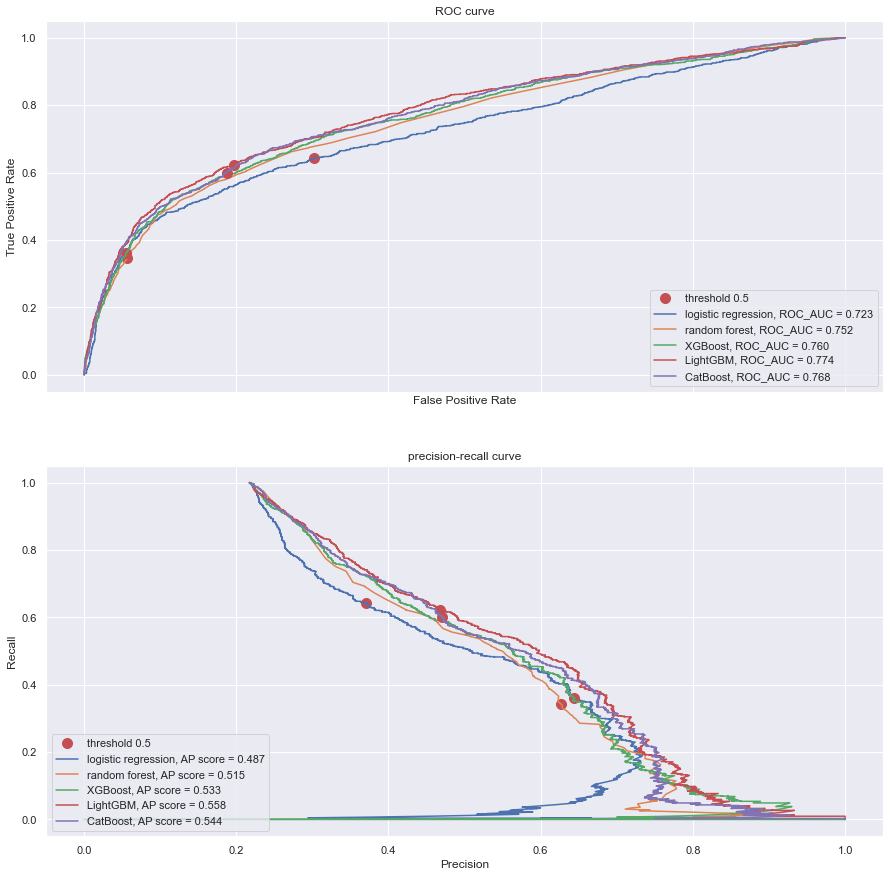

In [39]:
X_train2,X_valid,y_train2,y_valid = train_test_split(X_train,y_train, test_size=0.2, random_state=123)
classifiers_proba = {
    "logistic regression": pipe_lr,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
}
fig, ax = plt.subplots(2, sharex=True, figsize=[15, 15])
i=0
for (name, model) in classifiers_proba.items():
    model.fit(X_train2,y_train2)
    model_pred_proba=model.predict_proba(X_valid)[:, 1]
    model_roc_auc = roc_auc_score(y_valid, model_pred_proba)
    model_fpr, model_tpr, model_thresholds = roc_curve(y_valid,model_pred_proba)
    default_threshold = np.argmin(np.abs(model_thresholds - 0.5))
    if i==0:
        ax[0].plot(model_fpr[default_threshold],model_tpr[default_threshold],"or",markersize=10,label="threshold 0.5")
    else:
        ax[0].plot(model_fpr[default_threshold],model_tpr[default_threshold],"or",markersize=10)
    ax[0].plot(model_fpr,model_tpr, label = name+', ROC_AUC = %0.3f' % model_roc_auc)
    ax[0].set_xlabel("False Positive Rate", fontsize= 12)
    ax[0].set_ylabel("True Positive Rate", fontsize= 12)
    ax[0].set_title("ROC curve")
    ax[0].legend(loc="lower right")
    i=i+1
i=0    
for (name, model) in classifiers_proba.items():    
    model.fit(X_train2,y_train2)
    model_pred_proba=model.predict_proba(X_valid)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_valid, model_pred_proba)
    ap = average_precision_score(y_valid, model_pred_proba)
    if i==0:
        ax[1].plot(precision_score(y_valid, model.predict(X_valid)),recall_score(y_valid, model.predict(X_valid)),"or",markersize=10,label="threshold 0.5")
    else:
        ax[1].plot(precision_score(y_valid, model.predict(X_valid)),recall_score(y_valid, model.predict(X_valid)),"or",markersize=10)
    ax[1].plot(precision, recall, label= name+', AP score = %0.3f' % ap)
    ax[1].set_ylabel("Recall")
    ax[1].set_xlabel("Precision")
    ax[1].set_title("precision-recall curve")
    ax[1].legend(loc="lower left")
    i=i+1

<font color='green'>
None is beating the recall score of linear regression. However, LightGBM gives a better f1, AP and roc-auc scores. But I also look more into RandomForest and CatBoost. These classifiers have low recall scores, but with hyperparameter tuning might get good scores (They are overfitting).
    
In this problem there is a high cost for the bank when we have a large number of false negatives since no actions can be taken and high false positives when the bank needs to investigate a lot of customers who probably won't default.

<br><br>

## (Optional) 9. Feature selection <a name="9"></a>
<hr>
rubric={points:1}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<font color="green">
First, let's take a look at the coefficients of the best LogisticRegression model

In [40]:
pipe_lr.fit(X_train,y_train)
lr_coefs = pd.DataFrame(pipe_lr[1].coef_.T, index=column_names, columns=["Coefficient"])
lr_coefs.sort_values(by=["Coefficient"],ascending=False)

,Coefficient
EDUCATION_1,0.657445
EDUCATION_3,0.607398
EDUCATION_2,0.577704
PAY_1,0.494657
EDUCATION_6,0.441768
BILL_AMT2,0.169360
BILL_AMT5,0.099830
PAY_2,0.086081
BILL_AMT4,0.085652
PAY_3,0.079737


<font color="green">
We can see that top and bottom features are the most important ones. "EDUCATION_0" is a big negative number because in our data set, all customers in this category have repaid their statements (We explored this in EDA). In general, EDUCATION and PAY_1 have higher impacts. We can remove the least important features using Recursive feature elimination RFE. 

In [41]:
rfe_cv = RFECV(LogisticRegression(max_iter=2000), cv=5,min_features_to_select=5)
rfe_cv.fit(X_train_transformed, y_train)
features_select=np.array(column_names)
print(features_select[np.array(rfe_cv.support_, dtype=bool)])

['PAY_1' 'MARRIAGE_0' 'EDUCATION_0' 'EDUCATION_4' 'EDUCATION_5']


<font color="green">
Now we can put this linear feature selection into our pipelines and see whether we get improvements.

In [42]:
feature_selector=RFECV(LogisticRegression(max_iter=2000), cv=5,min_features_to_select=5)

pipe_rfe_lr = make_pipeline(
    preprocessor,feature_selector,
    LogisticRegression(max_iter=1000,class_weight="balanced", C=best_C),
)

pipe_rfe_rf = make_pipeline(
    preprocessor, feature_selector,
    RandomForestClassifier(class_weight="balanced")
)

pipe_rfe_catboost = make_pipeline(
    preprocessor,feature_selector,
    CatBoostClassifier(verbose=0,class_weights = (1, class_weight))
)


pipe_rfe_lgbm = make_pipeline(
    preprocessor,feature_selector,
    LGBMClassifier(class_weight="balanced")
)

classifiers_rfe = {
    "rfe_logistic regression": pipe_rfe_lr,
    "rfe_random forest": pipe_rfe_rf,
    "rfe_CatBoost": pipe_rfe_catboost,
    "rfe_LightGBM": pipe_rfe_lgbm,
}

In [43]:
results_rfe = {}
for (name, model) in classifiers_rfe.items():
    results_rfe[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring, cv=5
    )
pd.DataFrame(results_rfe)

,rfe_logistic regression,rfe_random forest,rfe_CatBoost,rfe_LightGBM
fit_time,22.9484 (+/- 1.8333),21.5836 (+/- 1.7665),24.4511 (+/- 2.1104),23.7445 (+/- 1.5265)
score_time,0.0296 (+/- 0.0031),0.0974 (+/- 0.0034),0.0352 (+/- 0.0053),0.0513 (+/- 0.0068)
test_accuracy,0.7685 (+/- 0.0271),0.7806 (+/- 0.0072),0.7805 (+/- 0.0072),0.7807 (+/- 0.0070)
train_accuracy,0.7692 (+/- 0.0266),0.7812 (+/- 0.0017),0.7811 (+/- 0.0018),0.7809 (+/- 0.0019)
test_precision,0.4861 (+/- 0.0457),0.5063 (+/- 0.0158),0.5060 (+/- 0.0159),0.5065 (+/- 0.0155)
train_precision,0.4877 (+/- 0.0441),0.5074 (+/- 0.0039),0.5073 (+/- 0.0040),0.5068 (+/- 0.0044)
test_recall,0.5240 (+/- 0.0304),0.5118 (+/- 0.0178),0.5118 (+/- 0.0178),0.5131 (+/- 0.0179)
train_recall,0.5243 (+/- 0.0256),0.5135 (+/- 0.0043),0.5136 (+/- 0.0042),0.5135 (+/- 0.0042)
test_f1,0.5024 (+/- 0.0213),0.5090 (+/- 0.0156),0.5088 (+/- 0.0156),0.5097 (+/- 0.0153)
train_f1,0.5034 (+/- 0.0157),0.5104 (+/- 0.0038),0.5105 (+/- 0.0038),0.5101 (+/- 0.0039)


<font color="green">

Feature selection has reduced the recall score! So we keep all features for now!

<br><br>

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={points:15}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. You may pick one of the best performing models from the previous exercise and tune hyperparameters only for that model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize)

<font color='green'>
    
## 1. CatBoost

In [44]:
param_dist = {
    "catboostclassifier__max_depth": randint(5, 15),
    "catboostclassifier__learning_rate": [ 0.1, 0.2, 0.3],
    "catboostclassifier__n_estimators": randint(1, 50),
}
random_search_cb = RandomizedSearchCV(pipe_catboost, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="recall",random_state=123)
random_search_cb.fit(X_train, y_train);

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


In [45]:
pd.DataFrame(random_search_cb.cv_results_)[
    [
        "param_catboostclassifier__max_depth",
        "param_catboostclassifier__learning_rate",
        "param_catboostclassifier__n_estimators",
        "mean_test_score",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().head().T

rank_test_score,1,2,3,4,5
param_catboostclassifier__max_depth,5,5,7,8,6
param_catboostclassifier__learning_rate,0.2,0.2,0.3,0.2,0.3
param_catboostclassifier__n_estimators,47,48,29,29,13
mean_test_score,0.625841,0.625653,0.624153,0.621526,0.618339
mean_fit_time,5.0041,4.839787,2.522839,2.945526,1.994329


In [46]:
print("The best recall score for CatBoost is %.3f "%random_search_cb.best_score_)

The best recall score for CatBoost is 0.626 


<font color='green'>
    
## 2. LightGBM

In [47]:
param_dist = {
    "lgbmclassifier__num_leaves": randint(1, 100),
    "lgbmclassifier__min_child_samples": randint(1, 100),
    "lgbmclassifier__max_depth": randint(1, 100),
}
random_search_lgbm = RandomizedSearchCV(pipe_lgbm, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="recall",random_state=123)
random_search_lgbm.fit(X_train, y_train);

In [48]:
pd.DataFrame(random_search_lgbm.cv_results_)[
    [
        "param_lgbmclassifier__num_leaves",
        "param_lgbmclassifier__min_child_samples",
        "param_lgbmclassifier__max_depth",
        "mean_test_score",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().head().T

rank_test_score,1,2,3,4,5
param_lgbmclassifier__num_leaves,8,16,40,26,28
param_lgbmclassifier__min_child_samples,49,19,85,97,95
param_lgbmclassifier__max_depth,62,78,3,47,86
mean_test_score,0.635216,0.630341,0.629403,0.627339,0.624525
mean_fit_time,0.662972,0.756248,0.725955,1.22374,0.976171


In [49]:
print("The best recall score for LGBM is %.3f"%random_search_lgbm.best_score_)

The best recall score for LGBM is 0.635


<font color='green'>
    
## 3. RandomForest

In [50]:
param_dist = {
    "randomforestclassifier__n_estimators": randint(1, 100),
    "randomforestclassifier__max_depth": randint(1, 100),
    "randomforestclassifier__class_weight": ["balanced"],
    "randomforestclassifier__max_features": ["auto"],
    "randomforestclassifier__bootstrap": [True],
    
}
random_search_rf = RandomizedSearchCV(pipe_rf, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="recall",random_state=123)
random_search_rf.fit(X_train, y_train);

In [51]:
pd.DataFrame(random_search_rf.cv_results_)[
    [
        "param_randomforestclassifier__n_estimators",
        "param_randomforestclassifier__max_depth",
        "param_randomforestclassifier__class_weight",
        "param_randomforestclassifier__max_features",
        "param_randomforestclassifier__bootstrap",
        "mean_test_score",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().head().T

rank_test_score,1,2,3,4,5
param_randomforestclassifier__n_estimators,93,85,35,84,67
param_randomforestclassifier__max_depth,8,3,28,26,40
param_randomforestclassifier__class_weight,balanced,balanced,balanced,balanced,balanced
param_randomforestclassifier__max_features,auto,auto,auto,auto,auto
param_randomforestclassifier__bootstrap,True,True,True,True,True
mean_test_score,0.58308,0.579704,0.35952,0.358959,0.35352
mean_fit_time,4.440506,2.064696,3.123852,7.63401,6.06681


In [52]:
print("The best recall score for RandomForest is %.3f"%random_search_rf.best_score_)

The best recall score for RandomForest is 0.583


# <br><br>

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={points:15}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`) (or any other methods of your choice) to explain feature importances of one of the best performing models. Summarize your observations. 

In [53]:
pipe_lgbm.fit(X_train, y_train)
eli5.explain_weights(
    pipe_lgbm.named_steps["lgbmclassifier"], feature_names=column_names
)

Weight,Feature
0.4083,PAY_1
0.0569,LIMIT_BAL
0.0523,BILL_AMT1
0.0517,PAY_AMT2
0.0383,PAY_AMT1
0.0360,PAY_AMT3
0.0349,PAY_AMT6
0.0343,PAY_AMT4
0.0307,AGE
0.0297,BILL_AMT2


In [54]:
pipe_lr.fit(X_train, y_train)
eli5.explain_weights(
    pipe_lr.named_steps["logisticregression"], feature_names=column_names
)

Explanation(estimator="LogisticRegression(C=10, class_weight='balanced', max_iter=2000)", description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='EDUCATION_1', weight=0.6574454759044395, std=None, value=None), FeatureWeight(feature='EDUCATION_3', weight=0.6073982087149641, std=None, value=None), FeatureWeight(feature='EDUCATION_2', weight=0.577704008008756, std=None, value=None), FeatureWeight(feature='PAY_1', weight=0.4946570188948766, std=None, value=None), FeatureWeight(feature='EDUCATION_6', weight=0.4417675716425173, std=None, value=None), FeatureWeight(feature='BILL_AMT2', weight=0.16936002702303943, std=None, value=None), FeatureWeight(feature='BILL_AMT5', weight=0.09983021539012155, std=None, value=None), FeatureWeight(feature='PAY_2', weight=0.08608130785376068, std=None, value=None), FeatureWeight(feature='BILL_AMT4', weight=0.08565184635344768, std=None, value=None)], neg=[FeatureWeight(feature='EDUCATION_0', weight=-2.077529576229717, std=None, value=None), FeatureWeight(feature='<BIAS>', weight=-0.7268591129077216, std=None, value=None), FeatureWeight(feature='MARRIAGE_0', weight=-0.6732084889047395, std=None, value=None), FeatureWeight(feature='EDUCATION_5', weight=-0.5669643283792256, std=None, value=None), FeatureWeight(feature='BILL_AMT1', weight=-0.4091772887140048, std=None, value=None), FeatureWeight(feature='EDUCATION_4', weight=-0.28772352466412265, std=None, value=None), FeatureWeight(feature='PAY_AMT2', weight=-0.2084784880040356, std=None, value=None), FeatureWeight(feature='PAY_AMT1', weight=-0.20755475400108558, std=None, value=None), FeatureWeight(feature='PAY_AMT3', weight=-0.1029480841704585, std=None, value=None), FeatureWeight(feature='BILL_AMT6', weight=-0.0970613355633359, std=None, value=None), FeatureWeight(feature='MARRIAGE_2', weight=-0.08882647430502781, std=None, value=None)], pos_remaining=7, neg_remaining=5), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

<font color="green">
    
Unlike LogisticRegression, LightGBM has different weights on features. As a matter of fact, for LightGBM, PAY_1 is the only feature that has a high weight.

In [55]:
# load JS visualization code to notebook
shap.initjs()

In [56]:
lgbm_explainer = shap.TreeExplainer(pipe_lgbm.named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_transformed);
print(train_lgbm_shap_values[1].shape);

(24000, 31)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [57]:
values = np.abs(train_lgbm_shap_values[1]).mean(0)
pd.DataFrame(data=values, index=column_names, columns=["SHAP"]).sort_values(by="SHAP", ascending=False)[:10]

,SHAP
PAY_1,0.475438
LIMIT_BAL,0.196634
BILL_AMT1,0.165305
PAY_AMT2,0.141257
PAY_AMT1,0.121020
PAY_AMT4,0.096538
PAY_AMT3,0.094167
PAY_3,0.087534
PAY_2,0.083366
PAY_6,0.063829


<font color="green">
    
## Dependence plot

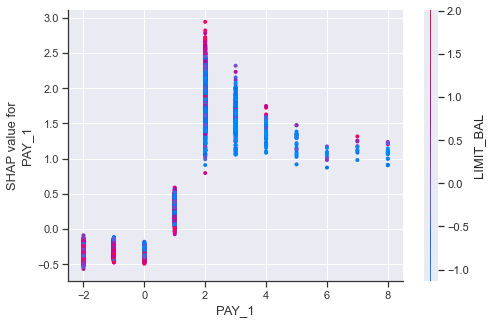

In [58]:
shap.dependence_plot("PAY_1", train_lgbm_shap_values[1], X_train_transformed)

<font color="green">
We see that a delay in the payment of the most recent balance, PAY_1, leads to higher SHAP values which draw the prediction towards default especially for those that have payment delay for 2 months. 

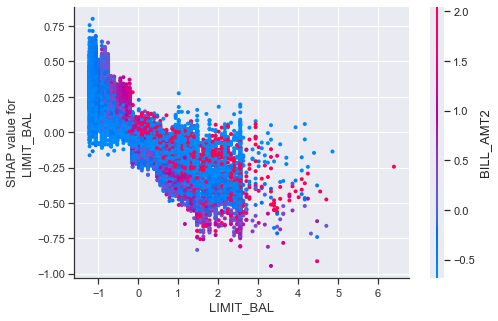

In [59]:
shap.dependence_plot("LIMIT_BAL", train_lgbm_shap_values[1], X_train_transformed)

<font color="green">
We see that the lower credit limit, the higher the SHAP value. Thus customers that have less credit limit default more. Or in another word, lower credit limit pushes the prediction towards default. 

<font color="green">
    
## Summary plot

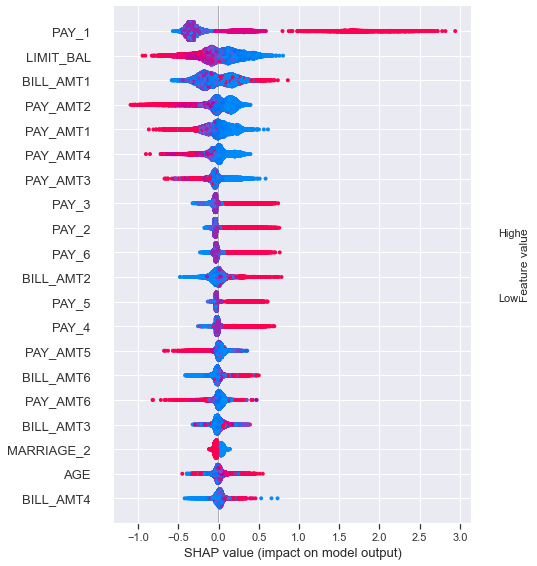

In [60]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_transformed)

<font color="green">
    
**PAY_X:**
This plot shows the PAY_1 is most important feature for predicting the default. Customers with delay payments default more than customers have fully paid their debt so far.

**LIMIT_BAL:**
The lower the credit limit, the higher the chance of default next month.
    
**PAY_AMTX:**
The higher the payment, the less chance of default next month.

<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={points:5}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 

<font color="green">
    
Overall we choose LightGBM. It not only has a high recall score (just a little bit smaller than LogesticRegression), but also the highest roc_auc and ap scores.

In [61]:
pipe = make_pipeline(
    preprocessor, 
    LGBMClassifier(
        class_weight="balanced",
        max_depth=random_search_lgbm.best_params_["lgbmclassifier__max_depth"],
        min_child_samples=random_search_lgbm.best_params_["lgbmclassifier__min_child_samples"],
        num_leaves=random_search_lgbm.best_params_["lgbmclassifier__num_leaves"],
    )
)
pipe.fit(X_train,y_train);
pred_proba=pipe.predict_proba(X_test)[:, 1]
pred=pipe.predict(X_test)

In [62]:
print("The recall score is %.3f"% recall_score(y_test, pred))

The recall score is 0.654


<font color="green">
    
The scores are consistent with the validation scores and looking at the fairly large data set we have avoided optimization bias. We also check std over cross validation to make sure nothing bizarre is happening.

<br><br>

## (Optional) 13. Explaining predictions 
rubric={points:1}

**Your tasks**

1. Take one or two test predictions and explain them with SHAP force plots.  

<font color="green">
Let's use SHAP on test data

In [63]:
X_test_transformed=pd.DataFrame(preprocessor.fit_transform(X_test),index=X_test.index, columns=column_names);
lgbm_explainer = shap.TreeExplainer(pipe.named_steps["lgbmclassifier"]);
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_transformed);
print(test_lgbm_shap_values[1].shape);

(6000, 31)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [64]:
values = np.abs(test_lgbm_shap_values[1]).mean(0)
pd.DataFrame(data=values, index=column_names, columns=["SHAP"]).sort_values(by="SHAP", ascending=False)[:10]

,SHAP
PAY_1,0.462343
LIMIT_BAL,0.195757
BILL_AMT1,0.131156
PAY_AMT1,0.096749
PAY_AMT3,0.092832
PAY_2,0.088910
PAY_3,0.084534
PAY_AMT2,0.083741
PAY_6,0.076829
PAY_5,0.054100


In [65]:
y_test_reset = y_test.reset_index(drop=True)
default_ind = y_test_reset[y_test_reset == 1].index.tolist()
repay_ind = y_test_reset[y_test_reset == 0].index.tolist()

<font color="green">
Let's sample from these two classes

In [66]:
ex_default_index = default_ind[10]
ex_repay_index = repay_ind[10]

<font color="green">
    
## Example with prediction: Default

In [67]:
pipe.named_steps["lgbmclassifier"].predict_proba(X_test_transformed)[ex_default_index]

array([0.15087827, 0.84912173])

In [68]:
pipe.named_steps["lgbmclassifier"].predict(X_test_transformed,raw_score=True)[ex_default_index]

1.7277291929550718

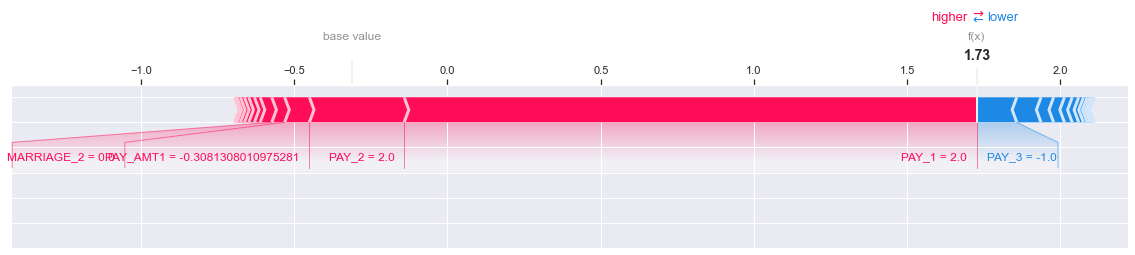

In [69]:
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][ex_default_index, :],
    X_test_transformed.iloc[ex_default_index, :],
    matplotlib=True,
)

<font color="green">
Mostly delay in payments of statements (PAY_1=2 and PAY_2=2) have contributed in predicting default.

<font color="green">
    
## Example with prediction: repay

<br><br>

In [70]:
pipe.named_steps["lgbmclassifier"].predict_proba(X_test_transformed)[ex_repay_index]

array([0.82151333, 0.17848667])

In [71]:
pipe.named_steps["lgbmclassifier"].predict(X_test_transformed,raw_score=True)[ex_repay_index]

-1.5266342572791796

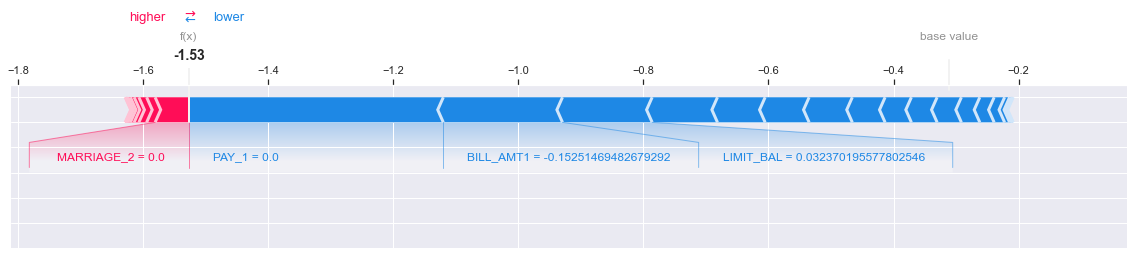

In [72]:
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][ex_repay_index, :],
    X_test_transformed.iloc[ex_repay_index, :],
    matplotlib=True,
)

<font color="green">
Mostly repaying the statement (PAY_1=0) and low (scaled BILL_AMT1<0) and higher credit limit (LIMIT_BAL>0) have contributed in predicting repay.

## 14. Summary of results <a name="13"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Report your final test score along with the metric you used. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 

In [73]:
print("The recall score is %.3f."% recall_score(y_test, pred))

The recall score is 0.654.


In [74]:
cm=confusion_matrix(y_test,pred)
print("\nConfusion Matrix\nTN=%d  FP=%d\nFN=%d   TP=%d"%(cm[0,0],cm[0,1],cm[1,0],cm[1,1]))


Confusion Matrix
TN=3708  FP=988
FN=451   TP=853


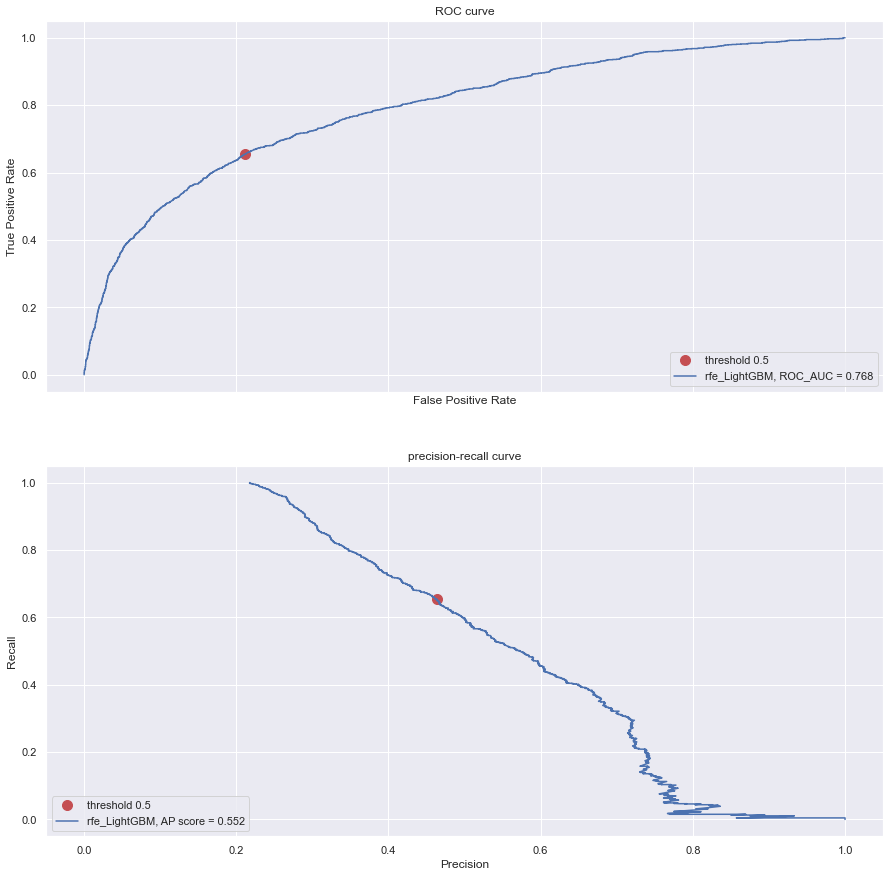

In [75]:
fig, ax = plt.subplots(2, sharex=True, figsize=[15, 15])
precision, recall, thresholds = precision_recall_curve(y_test, pred_proba)
fpr, tpr, thresholds = roc_curve(y_test,pred_proba)
roc_auc = roc_auc_score(y_test, pred_proba)
ap = average_precision_score(y_test, pred_proba)
default_threshold = np.argmin(np.abs(thresholds - 0.5))
ax[0].plot(fpr[default_threshold],tpr[default_threshold],"or",markersize=10,label="threshold 0.5")
ax[0].plot(fpr,tpr, label = name+', ROC_AUC = %0.3f' % model_roc_auc)
ax[0].set_xlabel("False Positive Rate", fontsize= 12)
ax[0].set_ylabel("True Positive Rate", fontsize= 12)
ax[0].set_title("ROC curve")
ax[0].legend(loc="lower right")

ax[1].plot(precision_score(y_test, pred),recall_score(y_test, pred),"or",markersize=10,label="threshold 0.5")
ax[1].plot(precision, recall, label= name+', AP score = %0.3f' % ap)
ax[1].set_ylabel("Recall")
ax[1].set_xlabel("Precision")
ax[1].set_title("precision-recall curve")
ax[1].legend(loc="lower left")


<font color="green">
    
- We see that recall is 65% and precision is about 46 percent. Bank might want to detect more True positives and less false negatives. They can change the threshold but the cost would be more false positives as shown in the precision-recall curve.
    
- Linear feature selection using a Logistic regression failed to improve performance. Maybe using a non-linear feature selection help.
    
- We can try stacking as well. That might improve the overall performance.    

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 